<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/multivariate_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git

In [3]:
%%capture
!cd npmf && git pull

##General setup

In [4]:
import os
from collections import defaultdict
from datetime import datetime

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3

In [5]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3,"black"])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
np.random.seed(420)

#Lets build our multivariate experiment 😂✨KAWAIII ^^✨ 

## 1) Build timeseries dataframe 🎶🐱‍🚀

Define some function to easily generate many timeseries $y_t$ 

In [8]:
def wave_function(periods, horisontal_shift, vertical_shift, T):
    x = np.linspace(horisontal_shift,T+horisontal_shift,T)
    
    return np.sin(np.pi*periods*2*x)*(1-vertical_shift) + vertical_shift 

In [9]:
def rolling_mean(np_array, window_size):
    return np.convolve(np_array, np.ones(window_size)/window_size, mode='valid')

Visualise the function

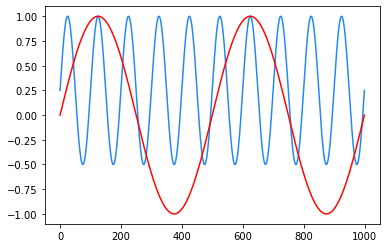

In [10]:
periods = 10
horisontal_shift = 100
vertical_shift = .25
T = 1000


plt.plot(wave_function(periods, horisontal_shift, vertical_shift, T))
plt.plot(wave_function(2, horisontal_shift, 0, T));

Make an outer to create $\mathcal{S}:\{y_t^1,y_t^2...y_t^k$\}, $|\mathcal{S}|=K$ we should also have $\mathcal{S_{sub}} \in \mathcal{S} | |y_t^i-y_t^j|, (i\neq j)$ 

Now we create a dataframe of $\mathcal{S}$ with indistingushable timeseries with distingushable $y_{t+h}$

In [11]:
def time_series_df(K,T, periods, horisontal_shift, vertical_shift, forecast_length):
    series = []
    output_series = [np.array([1 for i in range(forecast_length)]),
                     np.array([2*i for i in range(forecast_length)]),
                     np.array([2**i*(-1**i) for i in range(forecast_length)])]
    for j in range(len(output_series)):
        output_series[j] = output_series[j]/max(abs(output_series[j]))  
    
    for i in range(K):
        series.append(wave_function(periods, horisontal_shift, vertical_shift,T))
    TS_signal_df = pd.DataFrame(series)
    
    #add noise
    mu, sigma = 0, 0.1  
    noise = np.random.normal(mu, sigma, [K,T]) 
    
    TS_df = TS_signal_df + noise
    
    output_df = pd.DataFrame(int(K/3)*output_series,columns=[f"forecast_{x}" for x in range(forecast_length)])
    category_columns = pd.get_dummies(pd.Series(int(K/3)*["theta_0", "theta_1", "theta_2"], name="category",dtype="category"))


    TS_df = pd.concat([TS_df,output_df], join="inner",axis=1)
    TS_signal_df = pd.concat([TS_signal_df,output_df], join="inner",axis=1)
    return TS_df, TS_signal_df, category_columns

example_below

In [12]:
K = 9999  # make divisible by three
T = 500
forecast_length = 16

periods = 10
horisontal_shift = 100
vertical_shift = .25

TS_df, TS_signal_df, category_columns  = time_series_df(K,T,periods, horisontal_shift, vertical_shift, forecast_length)

In [13]:
TS_signal_df
pd.concat([category_columns, TS_signal_df], axis=1, join="inner") 

,theta_0,theta_1,theta_2,0,1,2,3,4,5,6,...,forecast_6,forecast_7,forecast_8,forecast_9,forecast_10,forecast_11,forecast_12,forecast_13,forecast_14,forecast_15
0,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
1,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
2,0,0,1,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,-0.001953,-0.003906,-0.007812,-0.015625,-0.031250,-0.062500,-0.125,-0.250000,-0.500000,-1.0
3,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
4,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0
9995,0,0,1,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,-0.001953,-0.003906,-0.007812,-0.015625,-0.031250,-0.062500,-0.125,-0.250000,-0.500000,-1.0
9996,1,0,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.0
9997,0,1,0,0.25,0.344187,0.436883,0.52662,0.611977,0.691603,0.764236,...,0.400000,0.466667,0.533333,0.600000,0.666667,0.733333,0.800,0.866667,0.933333,1.0


In [14]:
def min_search(one_d_points, loss_type, start, stop, iterations):
    min_loss = float("inf")
    min_y = None
    for y in np.linspace(start,stop,iterations):
        if loss_type == "abs":
            loss = np.abs(one_d_points-y).mean()
        else:
            loss = ((one_d_points-y)**2).mean()
        if loss < min_loss:
            min_loss = loss
            min_y = y
    return min_loss, min_y

def two_d_min_search(list_of_series, loss_type):
    min_losses = []
    ys = []
    for i in range(list_of_series[0].shape[0]):
        cross_sectional_min, y = min_search([list_of_series[0][i], list_of_series[1][i], list_of_series[2][i]], loss_type, -1, 1, 1000)
        min_losses.append(cross_sectional_min)
        ys.append(y)
    return np.array(min_losses), ys

0.3751661977172892


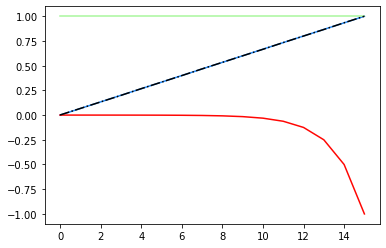

In [15]:
plt.plot(TS_df.iloc[1,-forecast_length:].values,color=main)
plt.plot(TS_df.iloc[2,-forecast_length:].values, color=main2)
plt.plot(TS_df.iloc[3,-forecast_length:].values, color=main3)

list_of_forecasts = [TS_df.iloc[0,-forecast_length:].values, TS_df.iloc[1,-forecast_length:].values, TS_df.iloc[2,-forecast_length:].values]

perfect_predict, ys = two_d_min_search(list_of_forecasts, "abs") 

mean_predict = (TS_df.iloc[1,-forecast_length:].values+TS_df.iloc[2,-forecast_length:].values+TS_df.iloc[3,-forecast_length:].values)/3

plt.plot(ys,linestyle="-.",color="black")

print(perfect_predict.mean())

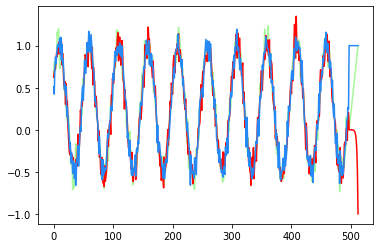

In [16]:
plt.plot(TS_df.iloc[1,3:].values, color=main3)
plt.plot(TS_df.iloc[2,3:].values, color=main2)
plt.plot(TS_df.iloc[3,3:].values, color=main);

All set 👍

## 2) Create a neural net 🦾🧠🦾                                     
                                        🦿🦿





### Simple Neural Net

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_size, out_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 512*2),
            nn.ReLU(),
            nn.Linear(512*2, 512),
            nn.ReLU(),
            nn.Linear(512, out_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Multivariate Network Architecture 🤗

In [18]:
class MultivariateNetwork(nn.Module):
    def __init__(self, lag_len, cat_len, out_len, hidden_dim):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Linear(lag_len, hidden_dim),
            nn.ReLU(),
        )

        self.predict = nn.Sequential(
            nn.Linear(hidden_dim + cat_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_len),
        )


    def forward(self, lags, cats):

        x = self.pre(lags)
        x = torch.cat((x, cats), dim=1)
        x = self.predict(x)

        return x

## 3) Lets make a training loop 🤣❤ 

### First version

In [19]:
def train(model, optimizer, loss_fn, data_train, data_val, one_hot_encoding, batch_number, forecast_window, epochs, device, show_progress=True):
    # print(model)
    train_losses = []
    val_losses = []
    it = tqdm(range(epochs), disable=not show_progress)
    for epoch in it: 
        for run_type in ["train", "val"]:
            model.train(run_type == "train")
            
            if run_type == "train":
                optimizer.zero_grad()
                
                mu, sigma = 0, 0.1
                noise = np.random.normal(mu, sigma, data_train.shape)
                noise[:,-forecast_window:] = 0

                data_train = data_train + noise
                
                if one_hot_encoding is not None:
                    data_train_encoded = pd.concat([one_hot_encoding, data_train], axis=1, join="inner")
                else:
                    data_train_encoded = data_train                
                data_shuffled = torch.tensor(data_train_encoded.sample(frac=1).values, dtype=torch.float32).to(device)

            else:
                if one_hot_encoding is not None:
                    data_val_encoded = pd.concat([one_hot_encoding, data_val], axis=1, join="inner")
                else:
                    data_val_encoded = data_val

                data_shuffled = torch.tensor(data_val_encoded.sample(frac=1).values, dtype=torch.float32).to(device)
            
            for batch in torch.split(data_shuffled, batch_number, dim=0):
                
            
                inputs = batch[:,:-forecast_window]
                actuals = batch[:,-forecast_window:]

                
                pred = model(inputs)
                loss = loss_fn(pred, actuals)
                
                if run_type == "train":
                    train_losses.append(loss.item())
                    loss.backward()

                    optimizer.step()
                else:
                    val_losses.append(loss.item())
        it.set_postfix({"train_loss": np.mean(train_losses), "val_loss": np.mean(val_losses)})

    return train_losses, val_losses

In [20]:
def run(use_multivariate, length_of_time_series=10, show_progress=True):
    #Training loop params
    forecast_window = 16
    amount_of_time_series = 999
    epochs = 200
    batch_size = 220
    
    #Wave params
    periods = 10
    horisontal_shift = 100
    vertical_shift = 0

    _, TS_signal, one_hot_encoding  = time_series_df(amount_of_time_series, length_of_time_series, periods, horisontal_shift, vertical_shift, forecast_window)

    df_train = TS_signal.iloc[:-int(amount_of_time_series/3),:]
    df_val = TS_signal.iloc[-int(amount_of_time_series/3):,:]

    loss_fn = nn.L1Loss()
    
    # print(f"use_multivariate: {use_multivariate}")
    if use_multivariate:        
        model = NeuralNetwork(length_of_time_series + one_hot_encoding.shape[1], forecast_window).to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001) 
        return train(model, optimizer, loss_fn, df_train, df_val, one_hot_encoding, batch_size,forecast_window, epochs, device, show_progress)
    
    else:
        model = NeuralNetwork(length_of_time_series, forecast_window).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        return train(model, optimizer, loss_fn, df_train, df_val, None, batch_size,forecast_window, epochs, device, show_progress)


### Second version

In [21]:
def train_multivar(model, optimizer, loss_fn, data_train, data_val, one_hot_encoding, batch_number, forecast_window, epochs, device):
    # print(model)
    train_losses = []
    val_losses = []
    it = tqdm(range(epochs), disable=True)
    for epoch in it: 
        for run_type in ["train", "val"]:
            model.train(run_type == "train")
            
            if run_type == "train":
                optimizer.zero_grad()
                
                mu, sigma = 0, 0.1
                noise = np.random.normal(mu, sigma, data_train.shape)
                noise[:,-forecast_window:] = 0

                data_train = data_train + noise
                data_encoded = pd.concat([one_hot_encoding, data_train], axis=1, join="inner")

            else:
                data_encoded = pd.concat([one_hot_encoding, data_val], axis=1, join="inner")

            data_shuffled = torch.tensor(data_encoded.sample(frac=1).values, dtype=torch.float32)
            
            for batch in torch.split(data_shuffled, batch_number, dim=0):

                inputs = batch[:,:-forecast_window].to(device)
                actuals = batch[:,-forecast_window:].to(device)

                pred = model(inputs[:, 3:], inputs[:, 0:3])
                loss = loss_fn(pred, actuals)
                
                if run_type == "train":
                    train_losses.append(loss.item())
                    loss.backward()

                    optimizer.step()
                else:
                    val_losses.append(loss.item())
        
        it.set_postfix({"train_loss": np.mean(train_losses), "val_loss": np.mean(val_losses)})

    return train_losses, val_losses

In [22]:
def run_multivar(hidden_dim):
    #Training loop params
    forecast_window = 16
    amount_of_time_series = 999
    length_of_time_series = 500
    epochs = 200
    batch_size = 111
    
    #Wave params
    periods = 10
    horisontal_shift = 100
    vertical_shift = 0

    _, TS_signal, one_hot_encoding  = time_series_df(amount_of_time_series,length_of_time_series,periods, horisontal_shift, vertical_shift, forecast_window)

    df_train = TS_signal.iloc[-int(amount_of_time_series/3):,:]
    df_val = TS_signal.iloc[:-int(amount_of_time_series/3),:]

    loss_fn = nn.L1Loss()
    
    model = MultivariateNetwork(length_of_time_series, one_hot_encoding.shape[1], forecast_window, hidden_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return train_multivar(model, optimizer, loss_fn, df_train, df_val, one_hot_encoding, batch_size, forecast_window, epochs, device)

## 4) Finally run experiments

### First experiment

In [ ]:
train_losses_multi, val_losses_multi = run(use_multivariate=True)
train_losses_uni, val_losses_uni = run(use_multivariate=False)

In [ ]:
plt.plot(rolling_mean(train_losses_multi, 150),color=main);
plt.plot(rolling_mean(train_losses_uni, 150),color=main2);
plt.axhline(y=perfect_predict.mean(), color="black", linestyle='-.')
plt.show()

In [ ]:
plt.plot(rolling_mean(val_losses_multi,150), color=main, label="Multivariate")
plt.plot(rolling_mean(val_losses_uni,150),color=main2, label="Univariate")
plt.axhline(y=perfect_predict.mean(), color='black', linestyle='-.', label="Optimal univariate")
plt.legend(frameon=False)
plt.show()

The train loss converges to ≈0.28, and the validation loss is the neural net does not have sufficient information of what the underlyding data generating process is. 

### Second experiment

In [23]:
trains = defaultdict(list)
vals = defaultdict(list)

In [28]:
trials = 15
hds = [3, 8, 16, 32, 64, 96, 128, 160, 192, 230, 256, 320, 384, 400, 512, 650, 768, 1024, 1300, 1536, 1700, 2048][::]

n_runs = 0
tot_runs = trials * len(hds)

starttime = datetime.now()
elapsed = 0
remaining = 0

it = tqdm(total=tot_runs)

for n, hd in enumerate(hds, start=1):
    for i in range(trials):
        it.set_postfix_str(f"HD: {hd} ({n}/{len(hds)}), trial: {i+1}/{trials}")

        tra, val = run_multivar(hd)

        trains[hd].append(tra)
        vals[hd].append(val)

        n_runs += 1
        elapsed = datetime.now() - starttime
        remaining = (tot_runs - n_runs) * (elapsed / n_runs)
        it.update()


100%|██████████| 330/330 [31:11<00:00,  5.64s/it, HD: 2048 (22/22), trial: 15/15]

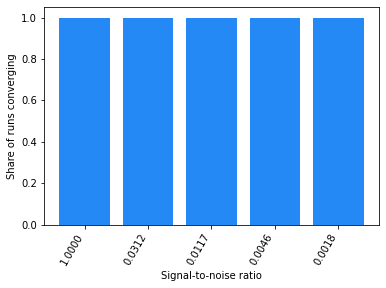

In [45]:
n_per_batch = 111
last_batches = 100
optimal = 0.3751661977172892

trains_sort = dict(sorted(trains.items(), key=lambda x: x[0]))

plot_data = []
for hd, runs in trains_sort.items():

    losses = np.array(runs)[:, -(n_per_batch*last_batches):].mean(axis=1)
    success_rate = (losses < optimal).mean()
    stn_ratio = 3 / hd

    plot_data.append((f"{stn_ratio:.4f}", success_rate))


plt.bar(*zip(*plot_data), label="Convergence ratio")
plt.xlabel("Signal-to-noise ratio")
plt.ylabel("Share of runs converging")
plt.xticks(rotation=60, ha='right');
#plt.legend(frameon=False);

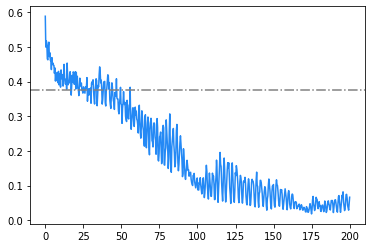

In [27]:
optimal = 0.3751661977172892

plt.plot(np.linspace(0, 200, len(trains[3][0])), trains[2048][0])
plt.axhline(y=optimal, color="grey", linestyle="-.");

### Third experiment: Try with original network instead

In [23]:
trains = defaultdict(list)
vals = defaultdict(list)

In [24]:
trials = 20
lags = range(3, 800, 30)

n_runs = 0
tot_runs = trials * len(lags)

it = tqdm(total=tot_runs)

for n, lag in enumerate(lags, start=1):
    for i in range(trials):
        it.set_postfix_str(f"Lags: {lag} ({n}/{len(lags)}), trial: {i+1}/{trials}")

        tra, val = run(use_multivariate=True, length_of_time_series=lag, show_progress=False)

        trains[lag].append(tra)
        vals[lag].append(val)

        it.update()

100%|██████████| 540/540 [54:55<00:00,  9.78s/it, Lags: 783 (27/27), trial: 20/20]

#### Test number of runs converging

In [48]:
data = rolling_mean(trains[33][5], 1)
optimal = 0.3751661977172892

plt.plot(np.linspace(0, 200, len(data)), data)
plt.axhline(y=optimal, color="grey", linestyle="-.");

IndexError: ignored

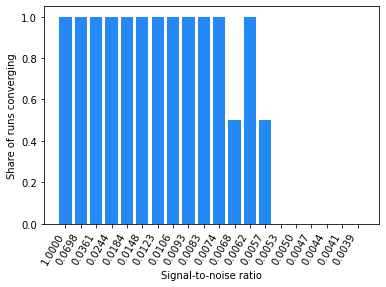

In [52]:
n_per_batch = 3
last_batches = 100
optimal = 0.3751661977172892

trains_sort = dict(sorted(trains.items(), key=lambda x: x[0]))

plot_data = []
for hd, runs in trains_sort.items():

    losses = np.array(runs)[:, -(n_per_batch*last_batches):].mean(axis=1)
    success_rate = (losses < optimal).mean()
    stn_ratio = 3 / hd

    plot_data.append((f"{stn_ratio:.4f}", success_rate))


plt.bar(*zip(*plot_data), label="Convergence ratio")
plt.xlabel("Signal-to-noise ratio")
plt.ylabel("Share of runs converging")
plt.xticks(rotation=60, ha='right');

#### Test how fast the runs converge for each SNR

In [38]:
def opt_index(d):

    for i, loss in enumerate(rolling_mean(d, 10)):
        if loss < optimal:
            return i

81

In [54]:
def convergence_pace(series):
    snrs = []
    datas = []

    for size, ds in series.items():
        snrs.append(f"{3 / size:.1e}")

        data = [opt_index(d) for d in ds]
        datas.append(data)

    datas = np.array(datas, dtype=np.float32)

    datas /= datas.max()

    return datas.T, snrs

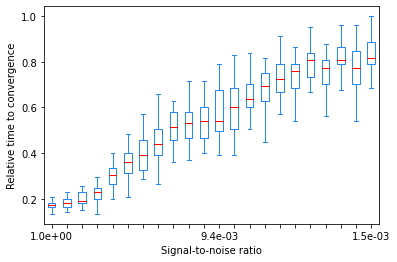

In [104]:
x, labels = convergence_pace(trains)

midpoint = labels[len(labels) // 2]
labels = labels[:1] + [""] * (len(labels) - 2) + labels[-1:]
labels[len(labels) // 2] = midpoint

fig, ax = plt.subplots()

ax.set_ylabel("Relative time to convergence")
ax.set_xlabel("Signal-to-noise ratio")
ax.boxplot(
    x,
    vert=True,
    labels=labels,
    medianprops={"color": main2},
    boxprops={"color": main},
    whiskerprops={"color": main},
    capprops={"color": main},
    showfliers=False,
);